In [1]:
from choice_theory_figures import *

Note: figures labeled 'interactive' will not actually be interactive unless they are 
created in a live Jupyter notebook. If you're viewing this as a page on the course 
static website, you'll be able to see the default figures but not change the sliders.


# Discrete Choice Theory

Discrete choice modeling is at the heart of many transportion planning models. This
is because so many aspects of travel represent discrete choices: do I 
walk or drive?  Buy a car or not?  Take the freeway or side streets? Go to the store 
on the way to work?  Which store? 

All of these choices share some common features:  

- they are selections from a bunch of categorical options, 
- the categories often lack a natural ordering (walking is not clearly "more" or "less" than
  driving, just different), and
- choosing one option means not choosing the other options.

Beyond these factual aspects of the choices, we will also define some reasonable
assumptions about these choices, namely:

- the decision makers (the people traveling, generally) make **rational choices**
  from among the options, choosing whichever option they think is best, and
- those judgements about which option is best are based on the **attributes of 
  the alternatives**, and we as modelers can observe at least some of the 
  relevant attributes that decision makers are considering.

## Mathematical Derivation

We can convert these reasonable assumptions, plus a few more assumptions that
maybe are a little less reasonable, into a mathematical model to represent
the choice process.

Let's suppose that each of the alternatives in a choice problem has some value
associated with it, and that the decision maker makes their choice by selecting
the alternative with the highest value.  We'll call that value **"utility"**, which
then makes this decision making process **"utility maximization"**.

Unfortunately, we can't actually observe utility, instead we can only observe
the actual or hypothetical choices that decision makers make.

Mathematically, decision maker $t$ chooses alternative $i$ from choices $C_t$ if and only if

$$
U_i \ge U_j \quad \forall j \in C_t.
$$

This is predicated on some formulation of utility

$$U_i = V_i + \varepsilon_i$$

where $V_i$ is a measured component, also called the *systematic utility*, and $\varepsilon_i$ is the the unobserved component, also called the *random utility*. Note that $\varepsilon_i$ isn't random from the perspective of the decision maker, it is only random from the perspective of the modeler. We can identify the probability of $t$ choosing alternative $i$ as

$$
\Pr_t(i | C_t) = \Pr(U_i \ge U_j, \forall j \in C_t) \\
= \Pr(V_i + \varepsilon_i \ge V_j + \varepsilon_j, \forall j \in C_t) \\
= \Pr(\varepsilon_j - \varepsilon_i \le V_i - V_j, \forall j \in C_t)
$$

In this last form we've grouped all the random utility together, which can be helpful.  If we can express these terms jointly, we have written this as a cumulative density function (CDF). Without making any particular assumption on the multivariate density function $f(\varepsilon)$ we can write the probability as an integral, like this:

$$
\Pr_t(i | C_t) = 
\int_{\varepsilon_i = -\infty}^{\infty} 
\int_{\varepsilon_j = -\infty}^{V_i - V_j + \varepsilon_i} 
f(\varepsilon) d\varepsilon_J d\varepsilon_{i-1} d\varepsilon_{i} 
$$

Particular assumptions about error distributions lead to particular model structures.

- If $\varepsilon$ has a multivariate normal distribution, we get a **Multinomial Probit** model. 
- If $\varepsilon$ has an IID Gumbel distribution, we get a **Multinomial Logit** model. **IID** means independent and identically distributed: each dimension has the same mean and variance, and there is no correlation across dimensions.

The Multinomial Probit is perfectly reasonable from a theoretical perspective, but it's inconvenient to work with in practice, because that integral in the equation above is messy, and the probit model doen't offer us a closed form analytic solution to get rid of it.  The Multinomial Logit, on the other hand, does have a bunch of really nice mathematical simplifications, which make it super easy to work with.  That's why you see logit models everywhere in transportation planning, and not probit models.

## The Gumbel Distribution

The normal distribution is (among other things) the 
distribution of the mean of a number of samples.  You've
likely heard of it before.  It's the default distribution
for a lot of things, and for good reasons.

The Gumbel distribution is much less well known.  It is
the (limit) distribution of the maximum (or the minimum) of 
a number of samples from a normal distribution.

In [2]:
# 5 thousand repetitions of samples taken from a normal distribution
draws = [
    np.random.normal(size=[1,5000]),
    np.random.normal(size=[10,5000]),
    np.random.normal(size=[100,5000]),
    np.random.normal(size=[1000,5000]),
    np.random.normal(size=[10000,5000]),
    np.random.normal(size=[100000,5000]),
]  

In [3]:
figure_gumbel_draws(draws)

<xmle.Elem 'div' with 1 children>

The gumbel distribution is available in the `scipy.stats` package,
under the name `gumbel_r` for the right-skewed version associated
with the maximum, or the mirrored `gumbel_l` for the left-skewed version associated
with the minimum.

In [4]:
from scipy.stats import gumbel_r, norm

In [5]:
figure_gumbel_draws(draws, gumbel_r)

<xmle.Elem 'div' with 1 children>

Similar to the normal distribution, the Gumbel distribution is defined by two parameters, one for position and one for width.  These are similar to the mean and standard deviation that define the normal distribution, although the defining parameters are not themselves the mean and standard deviation of the Gumbel.

The probability density function (pdf) for `gumbel_r` is:

$$f(x; \mu, \sigma) = \frac{1}{\sigma} \exp\left(-\frac{x+\mu}{\sigma}\right) \exp\left(-\exp\left(-\frac{x+\mu}{\sigma}\right)\right)$$

The cumulative density function (cdf) for `gumbel_r` is:

$$F(x; \mu, \sigma) = \exp\left(-\exp\left(-\frac{x-\mu}{\sigma}\right)\right)$$

The Gumbel distribution is sometimes referred to as a *type I Fisher-Tippett
distribution*. It is a bell-shaped distribution but obviously not "the" bell curve, which is generally the normal distribution. It is assymetric, but as we'll see below that is not important in the context of discrete choice analysis.

We can plot the PDF and CDF functions to get a better idea of the differences.

In [6]:
figure_gumbel_vs_normal()

<xmle.Elem 'div' with 1 children>

The mode (peak) of the standard Gumbel distribution is at zero,
but the mean is $0.577$, because the distribution is skewed.  The variance is $\frac{\pi^2}{6} = 1.645$.  

### Scale and Translation

Some properties of the Gumbel distribution include the ability to scale and translate (shift) it. If $\varepsilon \sim G(\mu,\sigma)$, then

- You can define a scaled version by multiplying by some constant $\alpha$ against both characteristic parameters:
  - $\alpha\varepsilon \sim Gumbel(\alpha\mu,\alpha\sigma)$
  - mode (peak) = $\alpha\mu$
  - mean = $\alpha\mu + \alpha\sigma 0.577$
  - variance = $\frac{\pi^2 \alpha^2 \sigma^2}{6}$


- You can define a translated (shifted) version by adding only to the location parameter: 
  - ($\varepsilon + V) \sim Gumbel(\mu + V,\sigma)$ where $V$ is some non-random value
  - mode (peak) = $\mu + V$
  - mean = $\mu + V + \sigma 0.577$
  - variance = $\frac{\pi^2 \sigma^2}{6}$
  - outcome: the distribution can be shifted left or right with no change in shape or variance
  
We can simplify the derivation of the Multinomial Logit model by
assuming $\mu = 0$ and $\sigma = 1$ (Standard Gumbel).
We will examine effect of different values later.


## The Logistic Distribution

A handy property of the Gumbel distribution is that the difference between two independent 
Gumbel distributions (with same variance) is a **logistic distribution**.  

The probability density function is:

$$
\begin{align}
f(x; \mu, \sigma)  & = \frac{e^{-(x-\mu)/\sigma}} {s\left(1+e^{-(x-\mu)/\sigma}\right)^2} \\[4pt]
\end{align}
$$

The cumulative density function is:

$$
F(x; \mu, \sigma) = \frac{1}{1+\exp({-(x-\mu)/\sigma})}
$$

It looks like this:

In [7]:
figure_logistic_vs_normal()

<xmle.Elem 'div' with 1 children>

Unlike the Gumbel, the Logistic distribution is symmetric.  Since it is also
unimodal (one hump) the mean and mode (peak) are at the same value.  When it
is created by taking the difference between two IID Gumbels, this value is 
equal to the difference between the location parameters (peaks) of those
two Gumbels.

$\varepsilon_1 \sim Gumbel(V_1, 1)$

$\varepsilon_2 \sim Gumbel(V_2, 1)$

$\varepsilon_1 - \varepsilon_2 = \varepsilon_3 \sim Logistic(V_1-V_2, 1)$


## Maximium over Multiple Gumbels

Suppose we have two random variables, both with a Gumbel distribution, both with the same variance.

$$\varepsilon_1 \sim G(V_1, 1)$$

$$\varepsilon_2 \sim G(V_2, 1)$$

Then, the distribution of the maximum, i.e. $\max(\varepsilon_1, \varepsilon_2)$ is *also* a Gumbel distribution, and *also* with the same variance.  

$$\max(\varepsilon_1, \varepsilon_2) \sim G(V_\star, 1)$$

with $V_\star = \log\left(\exp(V_1)+\exp(V_2)\right)$.

By extension, the same holds for the maximum of any set of $N$ Gumbel distributions:

$$V_\star = \log\left(\sum_{j=1}^{N}\exp(V_j)\right)$$.

For obvious reasons, this term is called a "logsum". You will find that logsums are used in many places when working with discrete choice models.

## Deriving the Multinomial Logit Choice Model

Recall our utility formulation.  The probability of a decision maker choosing a particular alternative $i$ is equal to the probability that the utility $U_i$ is greater than or equal to the utility $U_j$ for all other possible choices $j$.  This is equivalent to writing:

$$
\Pr\left(U_i \ge \max(U_j, \forall j \ne i)\right)
$$

or

$$
\Pr\left(V_i + \varepsilon_i \ge \max(V_j + \varepsilon_j, \forall j \ne i)\right)
$$

or

$$
\Pr\left(V_i \ge \max(V_j + \varepsilon_j, \forall j \ne i) - \varepsilon_i\right)
$$


Some important features of this way of writing the probabilities:

- On the left side of the inequality we have just $V_i$ which is not a random variable.
- On the right side we have $\max(V_j + \varepsilon_j, \forall j \ne i)$ which is 
  a maximum of (shifted) Gumbel distributions, which then is itself a Gumbel distribution,
  let's call it $\varepsilon_\star$ which has a (shifted) location of $V_\star$.
- Then we take the difference of that Gumbel distribution and another (the one 
  for $\varepsilon_i$), which makes one logistic distribution.
- That one logistic distribution is the only term on the right side of the inequality.
- We therefore reduced our multi-dimensional integral from before to a one-dimensional
  integral on a single logistic distribution ... which conveniently has a closed form solution:
  the CDF:
  
$$
\Pr\left(V_i \ge \max(V_j + \varepsilon_j, \forall j \ne i) - \varepsilon_i\right) = 
\frac{1}{1+\exp(V_\star - V_i)}
$$

We can reformat this a bit to make it more obviously symmetric and generalizable: 

$$
\frac{1}{1+\exp(V_k - V_i)}
= \frac{1}{1+\exp(V_k)/\exp(V_i)} = \frac{\exp(V_i)}{\exp(V_i)+\exp(V_k)}
$$

And recall that $V^\star = \log\left(\sum_{j=1}^{N}\exp(V_j)\right)$, which leads to

$$
\Pr(i) = \frac{\exp(V_i)}{\sum_{j=1}^{N}\exp(V_j)}
$$

## Arbitrary Scale 

Consider what happens if set the scale of the Gumbel distributions in our utility
functions to some value other than 1:

The utility function for alternative $j$ is now

$$
U_j = V_j + \varepsilon_j,\quad \varepsilon_j \sim Gumbel(0,\mu)
$$



Let's take this but define a different scaled measure of utility $U^\prime$.

$$
\begin{align}
U^\prime_j &= \mu U_j \\
&= \mu (V_j + \varepsilon_j),\quad \varepsilon_j \sim Gumbel(0,1) \\
&=  \mu V_j + \mu\varepsilon_j,\quad \mu\varepsilon_j \sim Gumbel(0,\mu)
\end{align}
$$

You can see that the two different models are practically the same, except for the scale of the variance.

However, because we will be choosing the functional form of $V$ to best fit the data, we can scale the
values we get for $V$ and end up with an identical model with respect to the output probabilities.

If we were able to observe the *utility* values directly, we could identify a unique scale of the 
$\varepsilon$ terms that would fit best.  But because we can only observe the choices, we cannot
actually identify which scale is better, and we are free to choose any scale factor that is mathematically
convenient (i.e., 1).

## Arbitrary Location 


Consider what happens if set the location (mode) of the Gumbel distributions in our utility
functions to some value other than 0:

The utility function for alternative $j$ is now

$$
U_j = V_j + \varepsilon_j,\quad \varepsilon_j \sim Gumbel(\delta, 1)
$$

Let's take this but define a different shifted measure of utility $U^\prime$.

$$
\begin{align}
U^\prime_j &= V_j + \varepsilon_j,\quad \varepsilon_j \sim Gumbel(\delta, 1) \\
&= V_j + \delta + \varepsilon_j,\quad \varepsilon_j \sim Gumbel(0,1)
\end{align}
$$

As for the scale, we can push an arbitrary location adjustment from $\varepsilon$ into $V$, and end up with the same model with respect to probabilities.

## Too Much Arbitrary-ness in Location

Consider what happens if we introduce an arbitrary constant shift in utility for *every* alterantive.

What happens to the differences in utilities between alternatives?  

$$
V_i^\prime - V_j^\prime = (V_i + \delta) - (V_j + \delta) = V_i  - V_j 
$$

What happens to the probabilities of alternatives?  


$$
\Pr(i) = \frac{\exp(V_i + \delta)}{\sum_{j=1}^{N}\exp(V_j + \delta)}
= \frac{\exp(V_i)\exp(\delta)}{\sum_{j=1}^{N}\exp(V_j)\exp(\delta)}
= \frac{\exp(\delta)}{\exp(\delta)}\frac{\exp(V_i)}{\sum_{j=1}^{N}\exp(V_j)}
= \frac{\exp(V_i)}{\sum_{j=1}^{N}\exp(V_j)}
$$

- We can shift constants for all alternatives the same and get the same probability model.
- We pick any alternative arbitrarily and set the constant to zero and get the same probability model.
- **Only the differences in utility matter, not the absolute values.**

## Typical Form of Systematic Utility

In most transportation planning applications, the systematic utility is given as a **linear in parameters** function.

This means that the functional form of $V_{ti}$ for decision maker $t$ and alternative $i$ looks like

$$
V_{ti} = X_{ti} \beta_{i} = \sum_{k=1}^{K} X_{tik} \beta_{ik}
$$

You may recall from the `statsmodel` package that in order to include a y-intercept or constant term in the model, it was necessary to explicitly add a column of all 1's to the dataframe.  The same is generally true when expressing the utility function for a discrete choice model like this.

One important feature to keep track of here that is different from an ordinary least squares linear regression model: **only the differences in utility matter**.

This means that *something* needs to induce some differences in the systematic utility between alternatives.  That *something* can be:

- differences in the observed $X$ data values (e.g. the travel time is different for different modes), or
- differences in the $\beta$ parameter values across modes, or
- both.

It is important to pay attention to instances where observed data values do *not* vary across modes, and ensure
that the parameters *do* vary in those instances.  These are sometimes called alternative-specific variables.

(Yes, this is ironic, because the variables themselves are in fact not specific to the alternative.)

## Independence of Irrelevant Alternatives (IIA)

One important property of the MNL model is "Independence of Irrelevant Alternatives".

This refers to the fact that the ratio of choice probabilities between pairs of alternatives is independent of the availability or attributes of other alternatives.

$$
\frac{\Pr(i)}{\Pr(k)} = \frac{\exp(V_i)}{\sum_j \exp(V_j)}\frac{\sum_j \exp(V_j)}{\exp(V_k)}
=\frac{\exp(V_i)}{\exp(V_k)} = \exp(V_i - V_k)
$$


How reasonable is this outcome?

Consider the selection of a birthday present for a child.

- Each child is offered two options to choose from: a red bicycle, or a pony.
- We observe across a sample of children that 75% choose the pony and 25% choose the bicycle.
- We then offer up a new set of choices: a red bicycle, a green bicycle, or a pony.
- As it turns out, these children are all colorblind (it runs in the family) and they can't see any difference between the two bicycles.


- What do we expect the choice probabilities to be?
- What does the MNL model predict the choice probabilities will be?
- What causes this?

## Elasticities of the MNL Model

### Direct Effects

The *direct elasticity* is the relative change in the probability of selection of an alternative with respect to a marginal change in one of the attributes of that alternative.  So, if you make an option a little bit better, how many more people would you expect to choose it?  Mathematically,

$$
\frac{\partial P_i}{\partial X_{ik}} = P_i (1-P_i) \beta_k
$$

$$
\eta ^{P_i} _{X_{ik}} =  \frac{\partial P_i}{\partial X_{ik}} \frac{X_{ik}}{P_i}
= (1-P_i) X_{ik} \beta_k
$$


We can see the direct elasticity of an alternative is related to its probability: 
    
- When the probability is high and it is chosen a lot, the elasticity is lower.
  Making a very popular choice a little bit better will not make very many more people
  choose it, as most people are already choosing it.  Thus, changing the attributes of the 
  alternative won't impact demand too much.
- When it is chosen infrequently, the elasticity is higher, and changing attributes 
  of the alternative might impact demand more (all else equal).  If it's not very popular currently,
  then the potential market share gains, especially as a percentage of the existing market share,
  can be much bigger.

### Cross Effects

The cross elasticity is the relative change in the probability of selection of one alternative with respect to a marginal change in one of the attributes of a *different* alternative. Mathematically,

$$
\frac{\partial P_j}{\partial X_{ik}} = - P_i P_j \beta_k
$$

$$
\eta ^{P_j} _{X_{ik}} =  \frac{\partial P_j}{\partial X_{ik}} \frac{X_{ik}}{P_j}
= P_i X_{ik} \beta_k
$$


Notice that the cross elasticity is not a function of the attributes of probability of $j$!  This is another manifestation of the IIA property.

When changing the attributes of any one alternative, the percentage change in the probabilities for all other alternatives is the same regardless of the alternative. 

## Estimating Model Parameters

Let us suppose we have some observations of trips taken by Car or Bus. We will represent the utility only with travel time and travel cost. Here we have a couple of observations:

In [11]:
data2

,obs,mode,time,cost,chosen
0,1,bus,20,10,True
1,1,car,10,20,False
2,2,car,12,16,True
3,2,bus,21,14,False


We can plot each observation seperately, showing the chosen and unchosen alternatives.
Since there are only two alternatives for each observation, the graph is quite simple.

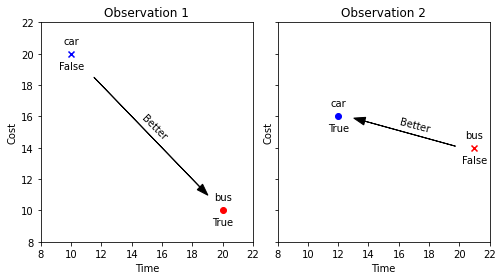

In [12]:
figure_two_observations()

In addition to the observations, these figures also include some notes about the implied utility of the two alternatives.  To create a model for this, we need to find a set of parameters that will allow us predict the choices: the utility of each choice should be better than that for each non-choice.  If we map a utility function onto these figures, both "better" arrows should be pointing uphill. 

Let's visualize some different fields of utility functions.

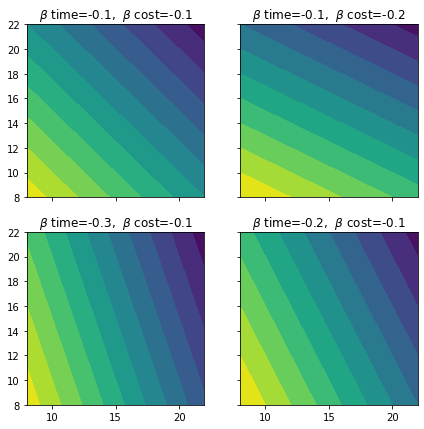

In [13]:
figure_four_fields()

The contour lines on these fields are "iso-utility" lines, 
defined as a series of parallel lines where the value of time 
(i.e. the ratio between the parameters on time and cost)
are represented by the inverse of the slope.

We want to pick an set of parameters that define a field where the actually chosen 
alternatives are all uphill from the non-chosen alternatives.

Does this work?

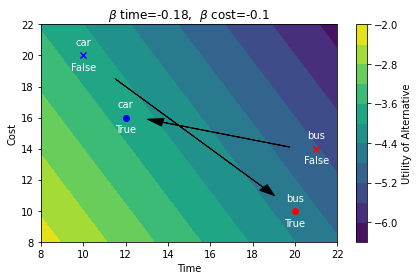

In [14]:
figure_two_observations_on_field(beta_time=-0.18, beta_cost=-0.1)

How about this?

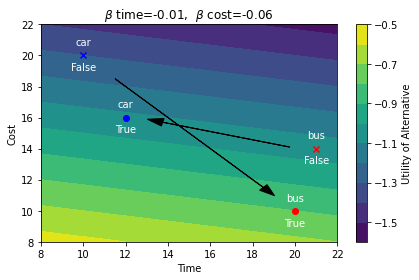

In [15]:
figure_two_observations_on_field(beta_time=-0.01, beta_cost=-0.06)

How about this?

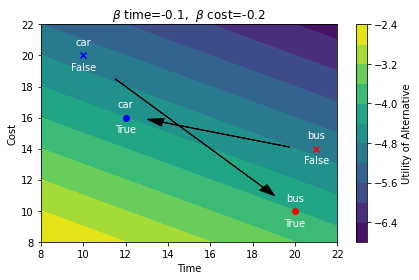

In [16]:
figure_two_observations_on_field(beta_time=-0.1, beta_cost=-0.2)

With both arrows pointing uphill, we found a set of parameters that works to explain 
these observations.

This visualization is kind of busy.  We can simplify it by reducing each
observation to a single point, by mapping the differences in time and cost,
instead of the raw values.  (Hey, remember "only the differences matter"?)

In [17]:
diffs2

,obs,choice,timediff,costdiff
0,1,bus,10,-10
1,2,car,9,-2


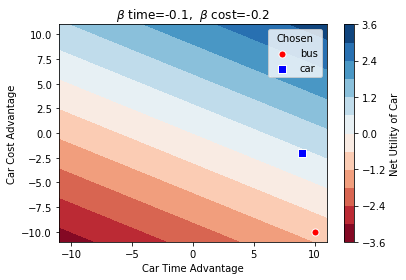

In [18]:
figure_two_differences_on_field(beta_time=-0.1, beta_cost=-0.2)

This figure makes it easier to explore a variety of different beta parameters.

In [19]:
interactive_two_differences_on_field(diffs2, beta_time=-0.1, beta_cost=-0.2)

    'data': [{'colorbar': {'len': 0.65,
                           'lenmode': 'f…

The color scale on this chart is "Net Utility of Car" but we're not really
interested in utility per se. What we're more interested in is the choices -- 
are we correctly predicting the usage of car and bus?  So let's apply
the MNL transformation to change utility into probability.

In [20]:
interactive_two_differences_with_probability(diffs2, beta_time=-0.1, beta_cost=-0.2)

    'data': [{'colorbar': {'len': 0.65,
                           'lenmode': 'f…

Now it's a bit clearer how we can manipulate our parameters to keep the choices correctly segregated.

What about if we have a few more data points?

In [21]:
diffs9

,obs,choice,timediff,costdiff
0,1,car,9,-7
1,2,bus,-8,-5
2,3,bus,4,-6
3,4,bus,-7,-2
4,5,car,2,0
5,6,bus,1,-5
6,7,car,-3,4
7,8,bus,-2,-7
8,9,car,5,0


Can we find a solution that correctly predicts all the data points?  This interactive
figure marks observations that are unambiguously incorrect (less than 50% probability 
assigned to the actually chosen alternative) with an "X" and
observations that are definitely correct (greater than 95% probability 
assigned to the actually chosen alternative) with a dot.

In [22]:
interactive_two_differences_with_probability(diffs9, beta_time=-0.1, beta_cost=-0.2, correct=True)

    'data': [{'colorbar': {'len': 0.65,
                           'lenmode': 'f…

What if there's some mixing of the data, so you can't neatly divide it with a clean line?

In [23]:
diffs19

,obs,choice,timediff,costdiff
0,1,car,9,-7
1,2,bus,-8,-5
2,3,bus,4,-6
3,4,bus,-7,-2
4,5,bus,2,0
5,6,bus,1,-5
6,7,car,-3,4
7,8,car,-2,-7
8,9,car,5,0
9,10,car,7,-6


In [24]:
interactive_two_differences_with_probability(diffs19, beta_time=-0.1, beta_cost=-0.2, correct=True)

    'data': [{'colorbar': {'len': 0.65,
                           'lenmode': 'f…

If our goal is to get everything right, it's hopeless.  We could change our goal,
and just try to maximize the total number of correct predictions.  That tends to be
problematic when the choices are very lopsided, with most observations choosing 
one alternative.  This happens a lot in transportation planning and especially in 
mode choices. So we'll need something to get at more subtly that just "correct" and
"incorrect".

That something is called "likelihood".  We can assign a likelihood to each observation,
which is the modeled probability that the choice is the actually observed choice. So, 
first we compute the probability of choosing each alternative.

In [26]:
beta_time = -0.1
beta_cost = -0.2

pr_car = 1/(1+np.exp(diffs19.timediff * beta_time + diffs19.costdiff * beta_cost))
pr_car

0     0.377541
1     0.141851
2     0.310026
3     0.249740
4     0.549834
5     0.289050
6     0.622459
7     0.167982
8     0.622459
9     0.377541
10    0.354344
11    0.249740
12    0.214165
13    0.249740
14    0.524979
15    0.141851
16    0.622459
17    0.182426
18    0.710950
dtype: float64

In [27]:
pr_bus = 1 - pr_car
pr_bus

0     0.622459
1     0.858149
2     0.689974
3     0.750260
4     0.450166
5     0.710950
6     0.377541
7     0.832018
8     0.377541
9     0.622459
10    0.645656
11    0.750260
12    0.785835
13    0.750260
14    0.475021
15    0.858149
16    0.377541
17    0.817574
18    0.289050
dtype: float64

Then we pick for each row the probability of the actually chosen alternative.

In [ ]:
likelihood = (diffsX['choice'] == 'car')* pr_car + (diffsX['choice'] == 'bus') * pr_bus

Then we want to find the joint likelihood of getting all these observations.

In [ ]:
likelihood.prod()

That's a tiny number.  Let's take the log of it.

In [ ]:
np.log(likelihood.prod())

Or instead of taking the product then the log, we can take the log first:

In [ ]:
np.log(likelihood).sum()

You might notice there's a teeny tiny difference in the two results, that arises because of the computer's numerical precision.  That tiny error isn't a big deal for this tiny data set, but as the data set gets bigger the errors compound.

We want to find the maximum likelihood, or log likelihood.  To do so, we can turn the likelihood into a function instead of a one-time computation.  Also, we'll return the *negative* of the log likelihood, as the default optimization tools in the `scipy` package do minimization instead of maximization.

In [ ]:
def likely(betas):
    pr_car = 1/(1+np.exp(diffsX.timediff * betas[0] + diffsX.costdiff * betas[1]))
    pr_bus = 1-pr_car
    likelihood = (diffsX['choice'] == 'car')* pr_car + (diffsX['choice'] == 'bus') * pr_bus
    return -np.log(likelihood).sum()

In [ ]:
likely([-0.1, -0.2])

Then we can use an optimization tool to find the best values.

In [ ]:
from scipy.optimize import fmin

In [ ]:
print(fmin.__doc__)

In [ ]:
best = fmin(likely, [-0.1, -0.2])
best

In [ ]:
likely(best)

In [ ]:
def likely_all(betas):
    pr_car = 1/(1+np.exp(diffsX.timediff * betas[0] + diffsX.costdiff * betas[1]))
    pr_bus = 1-pr_car
    likelihood = (diffsX['choice'] == 'car')* pr_car + (diffsX['choice'] == 'bus') * pr_bus
    return likelihood

In [ ]:
likely_all(best)

Let's see what the result looks like.

In [ ]:
beta_time, beta_cost = best
field = 1/(1+np.exp(grid[0] * beta_time + grid[1] * beta_cost))

fig, ax = plt.subplots()

cf = ax.contourf(space, space, field, levels=np.linspace(0,1,11))
cbar = fig.colorbar(cf)
cbar.ax.set_ylabel('Probability of Car')
diffsX['likely'] = likely_all(best)

for ch,gg in diffsX.groupby(['choice']):
    marker = 'o' if ch=='bus' else 's'
    color = 'r' if ch=='bus' else 'b'
    ax.scatter(gg.timediff, gg.costdiff, label=ch, marker=marker, color=color, edgecolor='w', s=gg.likely**2*300)
ax.set_xlabel('Car Time Advantage')
ax.set_ylabel('Car Cost Advantage')
ax.legend(title="Chosen");

One interesting feature of the model is that the 50% iso-probability contour passes 
exactly through the origin at (0,0).  This isn't coincidental, it's a definite outcome
from the fact that there's no alternative specific constants in the model.  Let's add one.

In [ ]:
def likely_2(betas):
    pr_car = 1/(1+np.exp(diffsX.timediff * betas[0] + diffsX.costdiff * betas[1] + betas[2]))
    pr_bus = 1-pr_car
    likelihood = (diffsX['choice'] == 'car')* pr_car + (diffsX['choice'] == 'bus') * pr_bus
    return -np.log(likelihood).sum()

def likely_2_all(betas):
    pr_car = 1/(1+np.exp(diffsX.timediff * betas[0] + diffsX.costdiff * betas[1] + betas[2]))
    pr_bus = 1-pr_car
    likelihood = (diffsX['choice'] == 'car')* pr_car + (diffsX['choice'] == 'bus') * pr_bus
    return likelihood

In [ ]:
best_2 = fmin(likely_2, [-0.1, -0.2, 0])
best_2

In [ ]:
beta_time, beta_cost, beta_0 = best_2
field = 1/(1+np.exp(grid[0] * beta_time + grid[1] * beta_cost + beta_0))

fig, ax = plt.subplots()

cf = ax.contourf(space, space, field, levels=np.linspace(0,1,11))
cbar = fig.colorbar(cf)
cbar.ax.set_ylabel('Probability of Car')
diffsX['likely2'] = likely_2_all(best_2)

for ch,gg in diffsX.groupby(['choice']):
    marker = 'o' if ch=='bus' else 's'
    color = 'r' if ch=='bus' else 'b'
    ax.scatter(gg.timediff, gg.costdiff, label=ch, marker=marker, color=color, edgecolor='w', s=gg.likely2**2*300)
ax.set_xlabel('Car Time Advantage')
ax.set_ylabel('Car Cost Advantage')
ax.legend(title="Chosen");

## Understanding Maximum Likelihood

Recall we identified that the likelihood was different from the probability:
    
- Probability is the chance of getting an outcome as a function of the data, 
  given a model and its parameters: $P_i(X | \beta)$

- Likelihood is the chance of getting an outcome as a function of the model 
  parameters, given the data: $L_i(\beta | X)$

Finding the maximum likelihood is finding the parameters that maximize the chance that
the model would create the observed data.  Equivalently, finding the maximum of the 
log of likelihood, as the logarithm is a monotonic transformation of positive values: if $a > b > 0$ then $\log(a) > \log(b)$.

For our two dimensional example above, we can visualize the log likelihood by plotting it
on a figure:

In [ ]:
beta_space = np.linspace(-0.5,0.5)
beta_grid = np.meshgrid(beta_space, beta_space)
beta_LL = np.zeros_like(beta_grid[0])

In [ ]:
for i,b in enumerate(zip(beta_grid[0].ravel(), beta_grid[1].ravel())):
    beta_LL.ravel()[i] = -likely(b)

In [ ]:
fig, ax = plt.subplots()
cf = ax.contourf(beta_space, beta_space, beta_LL, levels=15)
cbar = fig.colorbar(cf)
cbar.ax.set_ylabel('Log Likelihood')

The maximum likelihood is found at the peak of this hill.  Finding that peak by brute force (i.e. plotting this whole figure) is a wildly inefficient way of finding the maximum likelihood, so we don't generally do this.  Instead, some algorithm is used to systematically converge to this point.  The result is sometimes labeled as the "log likelihood at convergence".

But, it is useful to see this visually in this simple two dimensional example to conceptualize the process.  And it highlights another convenient mathematical features of using the MNL model with a linear-in-parameters utility function: the log likelihood function can be proven to be globally concave, meaning that there is always one and only one set of parameters that will maximize it, and they can be found by moving uphill from any point until the the top is found.

We can also use the shape of this likelihood function at the peak to describe the standard error of the estimate.

- If the shape of the hill is very pointy, and likelihood drops very quickly as we move away from the maximum, that tells us that the standard error of the estimate is small -- we are very confident that the true value of the estimator is very close to that peak.  

- If, on the other hand, the top of the hill is relatively flat, and likelihood drops very slowly as we move away from the maximum, that tells us that the standard error of the estimate is large -- we are not confident that the true value of the estimator is very close to that peak.  

In mathematical terms, the standard error of the estimate is the inverse of the 2nd derivative of the log likelihood with respect to the parameters.

## Goodness of Fit

The log likelihood achieved at the converged values, $LL(\hat\beta)$ can be used to generate an overall measure of the "goodness of fit" of a discrete choice model.  We can compare the log likelihood against better and worse models to create the measure.

The "best" possible model in this case is clearly well defined, as it would accurately predict every observation with certainty every time, yielding a likelihood of 1.0, and a log likelihood of zero.

The "worst" model is tricky, as we cannot simply take a model that never predicts the correct choice.  Such a model would have a likelihood of zero, and a log likelihood of negative infinity.  But, to create such a model, we would need to have some information about the process and use that information to intentionally "get it wrong" with certainty.  Instead, we can contemplate a model that predicts every alternative as equally probable for every decision maker, using no information whatsoever to improve our predictions.  This model would have non-zero probability for every chosen alternative, and has a well defined and finite log likelihood. We'll call this model the "Null" model, and write the log likelihood of this model as $LL(\emptyset)$.

### Rho Squared

Because we use data to *maximize* the log likelihood, we are guaranteed to achive a log likelihood for a model that uses data somewhere in between these two extremes.  The goodness of fit measure $\rho^2_\emptyset$ (rho squared with respect to the null model) represents the fraction of the distance moved from the null model to the perfect model.

$$
\rho^2_\emptyset = 1-\frac{LL(\hat\beta)}{LL(\emptyset)}
$$

However, especially for mode choice models, there is very often a massive imbalance between the mode 
choices.  You may find that the "drive alone" alternative is observed on well over half of all trips 
(at least in western countries) and representing it as "equally likely" against a variety of other 
alternatives results in an epicly poor model.  We can counteract this by defining a different "bad"
reference point: a model that consists only of alternative specific constants.  This model will use
no information other than the global market shares for each alternative, assigning the same relative
probability for each alterantive to all decision makers.

The goodness of fit measure $\rho^2_c$ (rho squared with respect to the constants only model) represents the fraction of the distance moved from the constants only model to the perfect model.

$$
\rho^2_c = 1-\frac{LL(\hat\beta)}{LL(c)}
$$

### Adjusted Rho Squared

A problem with the rho squared measures is that they always improve when adding variables to the model, regardless of whether the variable is relevant or not.  

To counter this, we can adjust the value to penalize models that add parameters without improving the log likelihood enough to be worth the extra degree of freedom.  

This adjusted rho-squared is given by:

$$
\bar\rho^2_\star = 1-\frac{LL(\hat\beta) - K_{\hat\beta}}{LL(\star) - K_{\star}}
$$

Where $K_{\star}$ is the number of parameters in the model $\star$.  For the null model, this is zero, and for
the constants only model, it is the number of constants in the model (i.e. the number of alteratives minus one).
Similarly, in the numerator $K$ represents the number of parameters in the relevant model.  

For this adjusted rho squared, the addition of parameters does not necessarily improve the goodness of fit.

## Hypothesis Testing

Just as for linear regression models, discrete choice models offer a number of hypothesis 
tests to compare models against each other.

### Single Parameter Tests

To test if a single parameter is significantly different from zero, we can use the $t$ statistic, similar to as it is used in simple linear regression.  For a parameter $\beta_i$, which has an estimate $\hat\beta_i$ with standard error of the estimate $s_i$,
$$
\frac{\hat\beta_i}{s_i} \sim t
$$

The degrees of freedom are formally the number of observations in the sample minus the 
number of parameters in the model, but in practice this isn't important, as the sample
size used for any transportation planning model is generally large enough that the $t$ distribution
will converge to the normal distribution.  This the critical value of $t$ for 95% confidence is about 1.96, 
and for 99% confidence it is about 2.58.

### Parameter Equality Tests

It is often interesting to determine if two parameters are statistically different from one another. This test is also based on the t-statistic, but it needs to account not only for the variance in the two estimators individually but also for the covariance (correlation) between them.  If we define a null hypothesis

$$
H_0 : \beta_i = \beta_j
$$

then we can derive

$$
\frac{\hat\beta_i - \hat\beta_j}{\sqrt{s_i^2 + s_j^2 - 2s_{ij}}} \sim t
$$

A sufficiently large value of this $t$ statistic will allow us to reject the null hypothesis with high confidence.  In this case, that allows us to say that we are confident the true values of the two parameters are not the same.

### Parameter Ratio Tests

We can use the same approach to check the ratio between two parameters.  In this case, we define a null hypothesis

$$
H_0 : \frac{\beta_i}{\beta_j} = K
$$

with the value $K$ being some fixed value. Or, equivalently

$$
H_0 : \beta_i = K\beta_j
$$

then we can derive

$$
\frac{\hat\beta_i - K\hat\beta_j}{\sqrt{s_i^2 + K^2 s_j^2 - 2Ks_{ij}}} \sim t
$$

A sufficiently large value of this $t$ statistic will allow us to reject the null hypothesis with high confidence.  In this case, that allows us to say that we are confident the ratio of the true values of the two parameters is not $K$.

### Full Model Likelihood Ratio Test

Instead of looking at the parameters individually, we can evaluate the performance of the entire model.
To do this we will us a likelihood ratio test.  This test is valid when we can construct two distinct
models that share the same structure, except one model has some restrictions placed on the parameter
values and the other does not.  These restrictions can take the form of fixing individual parameters
to specific values (commonly, to zero) or fixing pairs of parameters to have particular ratios (commonly,
one, which implies equality).

If the restricted model is the "true" model (our null hypothesis), then we would expect that the increase 
in likelihood found for the unrestricted model would be small.  If that increase in likelihood turns out 
to be sufficiently large, then we can reject the null hypothesis, and state with confidence that the 
restrictions are not valid.

Using the likelihood ratio test involves evaluating the test statistic:

$$
2\left( LL(U) - LL(R) \right) \sim \chi^2
$$

where $LL(U)$ is the log likelihood of the unrestricted model and $LL(R)$ is the log likelihood of the 
restricted model.  The $\chi^2$ (chi squared) distribution is characterized by a degrees of freedom, which 
is equal to the number of restrictions imposed.



In [ ]:
from scipy.stats import chi2

x = np.linspace(0,20)
for degfree in [1,2,5,10]:
    plt.plot(x,chi2.pdf(x, df=degfree), label=f'deg freedom={degfree}')
plt.title("Chi Squared Probability Density Function")
plt.legend();

To find the level of significance for rejecting a restricted model using a 
chi squared test (i.e. the probability that the likelihood ratio would be at 
least so big), use the `sf` method of the `chi2` distribution.

In [ ]:
chi2(df=10).sf(100)

### Full Model Non-Nested Hypothesis Test


Comparing two statistical models where one model is a restricted form of the other (i.e., by fixing some of the estimated parameters of the other model to some exogenously determined values, the resulting model is identical to the first model) is relatively straightforward, using the $\chi^{2}$ test. The approach when the models do not have this relationship (i.e., they are non-nested) is more complicated.

One approach to evaluating non-nested models is to specify a joint model, which is a relaxation of both models under consideration; the joint model contains all the data and parameters of both component models. This can potentially create a cumbersome non-parsimonious model, and the allows for four different results instead of merely two: the joint model can statistically reject, or fail to reject, each of the component models independently. It is generally more desirable, if possible, to employ a hypothesis test that allows the direct comparison of the two models in question. Various methodologies for doing so have been introduced in the literature; we review them here.


Horowitz (1983) offers a modified likelihood ratio index with respect to a null model, $\bar{\rho}_{H}^{2}$, for a given model as 

$$
\bar{\rho}_{H}^{2}=1-\frac{LL(\hat{\beta})-{K_{\hat\beta}}/{2}}{LL(\emptyset)}
$$

Later in the same work, Horowitz shows that an upper bound on the probability of a Type I error in Eq. 52 can be written as

$$
\Pr\left(\bar{\rho}_{P}^{2}-\bar{\rho}_{Q}^{2}>z\right)\leq\Phi\left[-\left(2zLL(\emptyset)\right)^{\frac{1}{2}}\right],
$$


with $Q$ as the hypothesized correct model, $P$ as an incorrect but apparently superior model, and $z$ as an arbitrary value greater than zero.  A Type I error as considered here is an incorrect rejection of the null hypothesis; here, it is the rejection of the inferior model when that model actually represents true underlying process. 

This bound depends on the fact that the models are non-nested, and does not apply otherwise. 

Unlike other more traditional hypothesis tests, we control only the bounded critical value, and the actual critical value may be higher. As a result, we are left with the probability of a Type II error being potentially much larger than it would be otherwise.

A Type II error is an incorrect failure to reject the null hypothesis when it is indeed false; here, it is the failure to reject the inferior model when the alternative model actually more closely represents the true underlying process.




In their popular textbook, Ben-Akiva and Lerman (1985) offer an alternative $\bar{\rho}^{2}$ formulation based on the Akaike information criterion (AIC), which is the version shown earlier.  This version penalizes models even more strongly for having extra parameters, resulting in a preference for even more parsimonious models.  But it results in a slightly different hypothesis test:

$$
\Pr\left(\bar{\rho}_{P}^{2}-\bar{\rho}_{Q}^{2}>z\right)\leq\Phi\left[-\left(-2zLL(0)+K_{P}-K_{Q}\right)^{\frac{1}{2}}\right],
$$

Importantly, the Horowitz bound only makes sense when $z>0$, therefore as noted subsequently by Ben-Akiva and Swait (1986), the Akaike bound only applies where $z>\max\left\{ 0,\frac{K_{P}-K_{Q}}{2LL(\emptyset)}\right\} $.  Thus, when the inferior model (as judged by the AIC) has more estimated parameters than the superior model, this hypothesis test given can be applied at any level of significance desired. However, in the more common scenario when the inferior model has fewer parameters than the superior model, the applicability of this second test is limited.

## Informal Tests

In addition to rigorous statistical testing backed up by the underlying theory, mode choice models 
should also be evaluated from a practical standpoint: Do the results make sense?

- Check the signs on parameters
    - Certain features, such as travel time and travel cost, should generally have negative 
      coefficients.  More travel time is less desirable.
    - Other features, especially ASC's, might have positive or negative values, and either
      might be OK.
      
- Check the relative values (ratios) of parameters
    - OVTT should be more negative than IVTT as a minute of OVTT creates more disutility
      than a minute of IVTT
    - Check groups of alternative-specific variables together.  Does a change in the 
      variable have the right relative impact on various modes?
    - Check the implied trade offs: especially the implied value of travel time

Determining what is "good" is a judgement you as the modeler needs to make.  Higher values
of $\rho^2$, sometimes even fairly large jumps, do not always result in a "better" model.